### Imports

In [1]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.8 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 91.1 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=297dd92fec1ade8690cb66ef9b38ca17ee81fe0e93e32fa446d7749709e55637
  Stored in directory: /home/onyxia/.cache/pip/wheels/1e/df/0f/e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
  Created wheel for peewee: filename=peewee-3.18.3-cp313-cp313-linux_x86_64.whl size=1044949 sha256=6a3a72fcc3d3a8d07f6c88a22fd77b91428cb41b17c9b57f75c5d8aca25a93c8
  Stored in directory: /home/onyxia/.cache/pip/wheels/8c/a9/a4/df972cd49f865ffde174d9c5b26f14f08f8a363ed31e10ff91
Successfully built multi

In [1]:
import pandas as pd
import numpy as np
import pickle
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression

## Data collection

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

/tmp/ipykernel_10368/801941168.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [4]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[*********************100%***********************]  504 of 504 completed

4 Failed downloads:
['JBHT']: Timeout('Failed to perform, curl: (28) Operation timed out after 10435 milliseconds with 136547 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['HON']: Timeout('Failed to perform, curl: (28) Operation timed out after 10081 milliseconds with 219233 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [5]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [2]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
len(selected_stocks)

368

In [5]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [6]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [7]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [8]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [11]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2025-11-24,XEL,73.783110,-79.705079,1.254567,-70.515747,21.364230,-4.616487,131.688495,-77.893140,6340300.0,5.071289e+08,0.001348,0.009527,0.311894,22.618797,-75.132233
2025-11-24,XOM,-95.259300,-248.747489,7.690347,-64.079967,-2.563889,-28.544605,148.481099,-61.100537,18034900.0,2.102599e+09,0.005521,0.051793,1.876834,5.126458,-92.624573
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000870,0.884709,0.380760,249.524614,151.773584
2025-11-24,ZBH,144.320907,-9.167282,297.280165,225.509851,45.926001,19.945284,398.187759,188.606124,2779100.0,2.594290e+08,0.000899,0.746583,0.237284,343.206166,245.455135
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,2.251958e+08,0.000402,0.670614,0.276422,534.909794,437.158763


In [12]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [13]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2000-01-04,A,-794.642113,-403.650359,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,1.920637e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.774326,-489.782573,NaN,NaN,NaN,NaN,NaN,NaN,512377600.0,4.048176e+08,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.875748,101.116005,NaN,NaN,NaN,NaN,NaN,NaN,10734887.0,8.536908e+07,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,NaN,NaN,NaN,NaN,NaN,NaN,84600.0,1.019541e+05,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.180681,-485.188927,NaN,NaN,NaN,NaN,NaN,NaN,7813200.0,1.193387e+08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XEL,73.783110,-79.705079,1.254567,-70.515747,21.364230,-4.616487,131.688495,-77.893140,6340300.0,5.071289e+08,0.001348,0.009527,0.311894,22.618797,-75.132233
2025-11-24,XOM,-95.259300,-248.747489,7.690347,-64.079967,-2.563889,-28.544605,148.481099,-61.100537,18034900.0,2.102599e+09,0.005521,0.051793,1.876834,5.126458,-92.624573
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000870,0.884709,0.380760,249.524614,151.773584


# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

# Baseline models

## Random Strategy

In [16]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [17]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).mean())

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

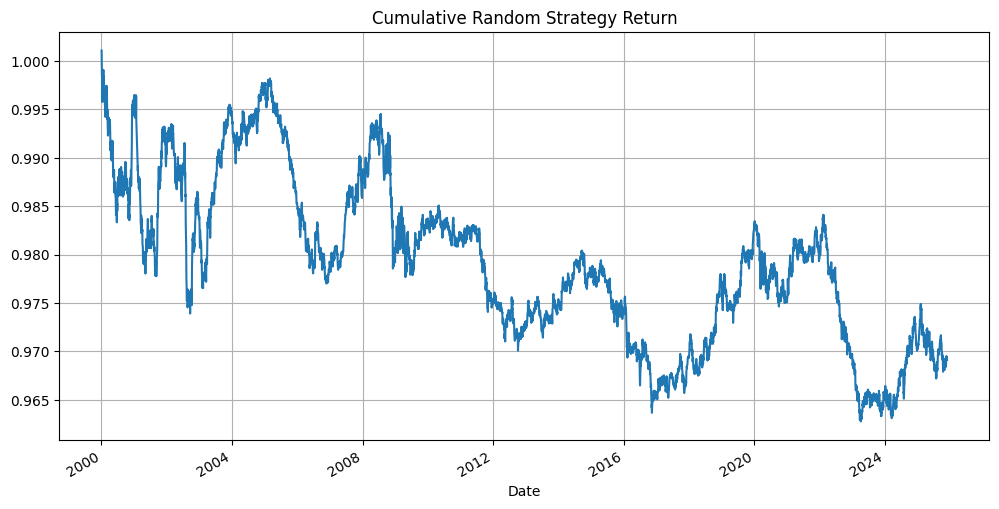

In [18]:
(random_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [19]:
random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252)

np.float64(-0.16954724071573635)

## Momentum Strategies

### Simple Momentum Strategy

In [20]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: 1 if y == 0 else (-1 if y == 9 else 0))
    return signal

In [21]:
df['momentum_hedged_signal'] = df.groupby('Date')['close_1d_ret_hedged'].transform(compute_signal)

In [22]:
df['momentum_hedged_signal'] = df.groupby('Ticker')['momentum_hedged_signal'].shift()

In [23]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret'].transform(compute_signal)

In [24]:
df['momentum_signal'] = df.groupby('Ticker')['momentum_signal'].shift()

In [25]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'hedged': (x['momentum_hedged_signal'] * x['close_1d_ret']).mean(),
        'unhedged': (x['momentum_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

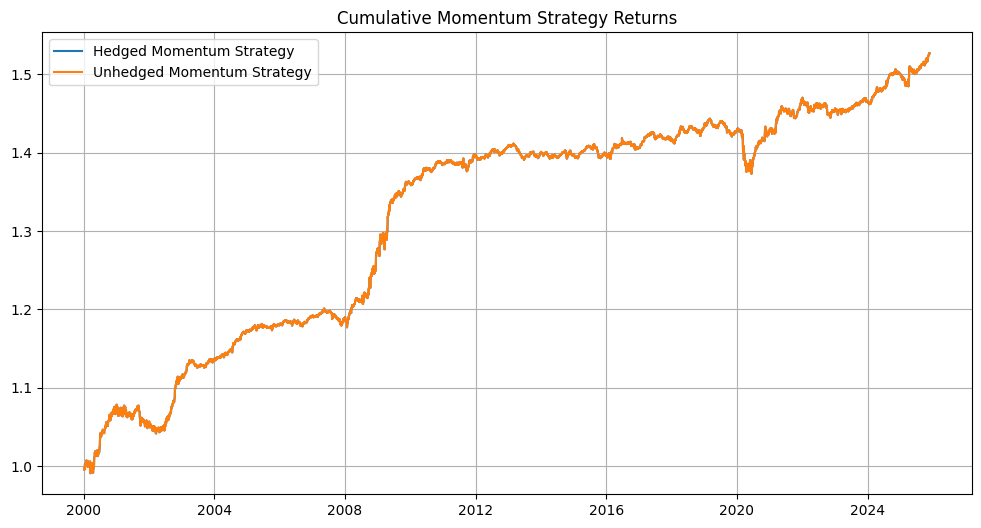

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(momentum_daily_returns['hedged'].cumsum() + 1, label='Hedged Momentum Strategy')
plt.plot(momentum_daily_returns['unhedged'].cumsum() + 1, label='Unhedged Momentum Strategy')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

hedged      0.971671
unhedged    0.971671
dtype: float64

### MACD Vol adjusted Strategy

In [18]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: 1 if y == 0 else (-1 if y == 9 else 0))
    return signal

In [14]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [ ]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [16]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [19]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [20]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [21]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [22]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).mean(),
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

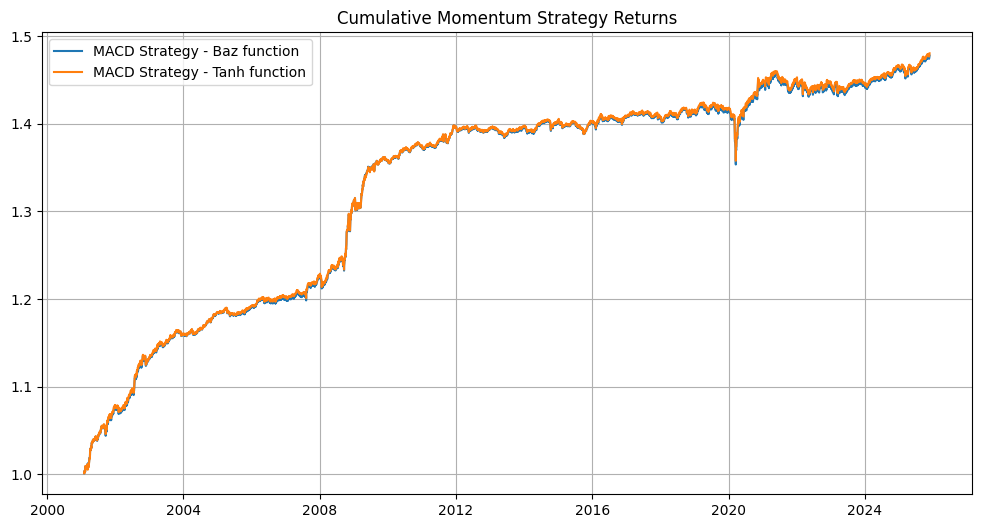

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(macd_daily_returns['baz'].cumsum() + 1, label='MACD Strategy - Baz function')
plt.plot(macd_daily_returns['tanh'].cumsum() + 1, label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz     1.130922
tanh    1.139835
dtype: float64

# Regress-then-rank Strategies 

## Linear Regression

### Feature factory

In [ ]:
def daily_metrics(group, feature, target, beta_global):
    reg = LinearRegression(fit_intercept=False)
    if len(group) < 2:
        return pd.Series({'beta': np.nan, 'bias': np.nan})
    reg.fit(group[[feature]], group[target])
    predictions = reg.predict(group[[feature]])
    bias = np.std(predictions)
    if reg.coef_[0]*beta_global < 0:
        bias *= -1
    return pd.Series({'bias': bias})

In [ ]:
def single_feature_metrics(df, feature, target, drop_extreme_perc=True, ts_bool=False, fit_intercept=False):
    global_reg = LinearRegression(fit_intercept=fit_intercept)
    if drop_extreme_perc:
        first_perc, last_perc = np.percentile(df[feature].dropna(), [1, 99])
        df_filtered = df[(df[feature]>=first_perc) & (df[feature]<=last_perc)]
    else:
        df_filtered = df.copy(deep=True)
    global_reg.fit(df_filtered[[feature]], df_filtered[target])
    predictions = global_reg.predict(df_filtered[[feature]])
    bias = np.std(predictions)
    stab = (predictions * df_filtered[target] > 0).mean() * 100
    beta_global = global_reg.coef_[0]
    if ts_bool:
        bias_ts = df_filtered.groupby('Date').apply(lambda x: daily_metrics(x, feature, target, beta_global))
        mean_bias_ts = bias_ts['bias'].mean()
        sharpe_ts = bias_ts['bias'].mean() / bias_ts['bias'].std() * np.sqrt(252)
        return bias, mean_bias_ts, stab, beta_global, sharpe_ts, bias_ts
    else:
        return bias, stab, beta_global

In [ ]:
linear_features

In [ ]:
all_linear_features = copy.deepcopy(linear_features)

In [ ]:
for feature in linear_features:
    print(feature)
    plt.hist(pd.Series(winsorize(df[feature], limits=0.001)).dropna(), bins=100)
    plt.title(f'{feature} hist')
    plt.show()

In [ ]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

In [ ]:
df.to_parquet('df.pq')

In [ ]:
for feature in tqdm(all_linear_features):
    df[feature] = winsorize(df[feature], limits=0.001)

In [ ]:
# for feature in linear_features:
#     print(feature)
#     plt.hist(df[feature].replace([-np.inf, np.inf], np.nan), bins=100)
#     plt.title(f'{feature} hist')
#     plt.show()
#     for feature_type in ['avg', 'zscore', 'sharpe']:
#         for window in [5, 30, 80]:
#             temp_feature = f'{feature_type}_{feature}_{window}d'
#             plt.hist(df[temp_feature].replace([-np.inf, np.inf], np.nan), bins=100)
#             plt.title(f'{temp_feature} hist')
#             plt.show()

In [ ]:
dict_results = {'feature': [], 'bias': [], 'mean_bias_ts': [], 'stability': [], 'beta': [], 'sharpe_ts': [], 'bias_ts': []}
for feature in tqdm(all_linear_features):
    bias, mean_bias_ts, stability, beta, sharpe_ts, bias_ts = single_feature_metrics(df[[feature, 'close_1d_ret']].dropna(), feature, 'close_1d_ret', drop_extreme_perc=False,  ts_bool=True)
    dict_results['feature'].append(feature)
    dict_results['bias'].append(bias)
    dict_results['mean_bias_ts'].append(mean_bias_ts)
    dict_results['stability'].append(stability)
    dict_results['beta'].append(beta)
    dict_results['sharpe_ts'].append(sharpe_ts)
    dict_results['bias_ts'].append(bias_ts)

In [ ]:
# with open("dict_results.pkl", "wb") as f:
#     pickle.dump(dict_results, f)

with open("dict_results.pkl", "rb") as f:
    dict_results = pickle.load(f)

In [ ]:
results_df = pd.DataFrame(dict_results).set_index('feature')
results_df['feature_type'] = pd.Series(results_df.index.str.split('_')).apply(lambda x: x[0] if x[0] in ['avg', 'zscore', 'sharpe'] else 'spot').values
results_df['window'] = pd.Series(results_df.index.str.split('_')).apply(lambda x: int(x[-1][:-1]) if (x[-1][-1]=='d' and x[-1]!='hedged') else 1).values
results_df['feature_name'] = np.where(results_df['feature_type']!='spot', pd.Series(results_df.index.str.split('_')).apply(lambda x: '_'.join(x[1:-1])), results_df.index)

In [ ]:
linear_features

In [ ]:
results_df.sort_values('mean_bias_ts').tail(50)

In [ ]:
results_df.loc['zscore_open_close_ret_60d', 'bias_ts'].cumsum().plot()

### Article features

In [14]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

In [ ]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in [21, 63, 126, 252]:
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_{window}_{i+1}'
        df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        df[f'macd_adj_{window}_{i+1}'] /= df[f'macd_adj_{window}_{i+1}'].rolling(252).std()
        df[f'macd_adj_{window}_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{window}_{i+1}'].shift(window+1)
        article_features.append(f'macd_adj_{window}_{i+1}')

In [16]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [17]:
for window in [21, 63, 126, 252]:
    df[f'macd_baz_signal_{window}'] = df[[f'macd_adj_{window}_1', f'macd_adj_{window}_2', f'macd_adj_{window}_3']].apply(phi_baz).sum(1).replace(0, np.nan)
    df[f'macd_baz_signal_{window}'] = df.groupby('Ticker')[f'macd_baz_signal_{window}'].shift()
    article_features.append(f'macd_baz_signal_{window}')

In [18]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,...,macd_adj_126_1,macd_adj_126_2,macd_adj_126_3,macd_adj_252_1,macd_adj_252_2,macd_adj_252_3,macd_baz_signal_21,macd_baz_signal_63,macd_baz_signal_126,macd_baz_signal_252
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,A,-794.642113,-403.650359,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,A,-640.376324,-659.579704,-241.422591,149.569162,-553.219522,-553.219522,617.596008,212.374028,5758642.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,A,-388.199255,-397.751472,-602.708987,-621.912367,-37.667337,-37.667337,976.625365,721.573184,2534434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,A,800.425117,533.125619,-267.231071,-276.783288,-120.968184,-120.968184,645.385957,504.156442,2819626.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,A,588.130822,476.852573,957.910729,690.611232,-157.485612,-157.485612,1111.698350,824.999445,2148446.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-18,ZBRA,-78.083821,4.823277,-264.194126,-202.637611,-67.570439,-37.081975,371.167457,198.540686,882900.0,...,-1.589747,-2.388633,-2.428926,-1.153714,-1.540884,-1.733824,-2.291355,-2.502216,-2.515289,-2.211048
2025-11-19,ZBRA,1.299127,-36.168951,-8.225393,27.781886,-69.858428,-22.958609,280.390229,140.956795,721400.0,...,-1.096826,-2.104040,-2.324837,-0.798364,-1.356532,-1.667602,-2.514433,-2.682081,-2.693585,-2.460734
2025-11-20,ZBRA,-110.161515,46.735746,8.664254,-15.936773,-7.365127,-20.232178,182.819108,53.052181,1011400.0,...,-0.461164,-1.620157,-2.083270,-0.336339,-1.048195,-1.503938,-2.369489,-2.541229,-2.560776,-2.286464


In [25]:
df[article_features].corr()

,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_21_1,macd_adj_21_2,...,macd_adj_126_1,macd_adj_126_2,macd_adj_126_3,macd_adj_252_1,macd_adj_252_2,macd_adj_252_3,macd_baz_signal_21,macd_baz_signal_63,macd_baz_signal_126,macd_baz_signal_252
avg_close_1d_ret_3d,1.000000,0.142248,0.764288,0.544703,0.382357,0.316954,0.212546,0.190406,0.706677,0.636186,...,0.731374,0.661557,0.537638,0.740488,0.667648,0.539070,0.465404,0.473858,0.477350,0.480850
avg_normalised_close_1d_ret_3d,0.142248,1.000000,0.108419,0.157794,0.054083,0.068232,0.032779,0.040382,0.148584,0.132539,...,0.148039,0.132864,0.107376,0.148359,0.132708,0.106416,0.102749,0.103701,0.104689,0.104905
avg_close_1d_ret_5d,0.764288,0.108419,1.000000,0.711474,0.493318,0.406428,0.273827,0.244162,0.655122,0.679578,...,0.685808,0.720148,0.632114,0.695705,0.729165,0.636349,0.597076,0.610986,0.616358,0.621582
avg_normalised_close_1d_ret_5d,0.544703,0.157794,0.711474,1.000000,0.347254,0.435469,0.205110,0.253647,0.690770,0.713266,...,0.688386,0.719584,0.629105,0.690549,0.720706,0.626494,0.645710,0.652237,0.654076,0.655794
avg_close_1d_ret_20d,0.382357,0.054083,0.493318,0.347254,1.000000,0.811631,0.554269,0.477550,0.197380,0.459544,...,0.184275,0.455346,0.663604,0.186504,0.465657,0.680354,0.465599,0.460731,0.464110,0.469057
avg_normalised_close_1d_ret_20d,0.316954,0.068232,0.406428,0.435469,0.811631,1.000000,0.454998,0.552738,0.239914,0.555791,...,0.213668,0.525640,0.766207,0.213781,0.531569,0.777181,0.555305,0.544279,0.546130,0.548274
avg_close_1d_ret_60d,0.212546,0.032779,0.273827,0.205110,0.554269,0.454998,1.000000,0.840330,0.015876,0.061803,...,0.025296,0.083552,0.280632,0.024747,0.083294,0.285018,0.121062,0.126267,0.120538,0.119608
avg_normalised_close_1d_ret_60d,0.190406,0.040382,0.244162,0.253647,0.477550,0.552738,0.840330,1.000000,0.025158,0.085028,...,0.035889,0.107069,0.339926,0.035713,0.106876,0.343404,0.153701,0.158500,0.152769,0.151896
macd_adj_21_1,0.706677,0.148584,0.655122,0.690770,0.197380,0.239914,0.015876,0.025158,1.000000,0.862461,...,0.951966,0.837764,0.585878,0.949937,0.833549,0.575678,0.511175,0.518991,0.519760,0.520239
macd_adj_21_2,0.636186,0.132539,0.679578,0.713266,0.459544,0.555791,0.061803,0.085028,0.862461,1.000000,...,0.814080,0.934588,0.838058,0.812077,0.933032,0.834584,0.761676,0.755271,0.756564,0.757740


### Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
ridge_reg = Ridge(fit_intercept=False)

In [ ]:
df = pd.read_parquet('df.pq')

In [ ]:
df.head()

In [ ]:
X = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# ---------------------------
# Expanding CV function
# ---------------------------
def expanding_cv_score(model, X, y, n_splits=5, lower=0.01, upper=0.01):
    """
    Performs expanding-window CV with winsorization applied to X.
    Winsorization limits are fit on each training window and applied to validation window.
    
    Parameters:
    - model: estimator with fit/predict
    - X: pandas DataFrame
    - y: pandas Series
    - n_splits: number of expanding CV splits
    - lower, upper: winsorization proportions
    """
    n_samples = len(X)
    split_size = (n_samples // 2) // n_splits  # size of each incremental step

    mse_list = []

    for i in tqdm(range(n_splits)):
        train_end = n_samples//2 + split_size * i
        val_end = n_samples//2 + split_size * (i + 1)

        # Slice windows
        X_train_cv = X.iloc[:train_end].copy()
        y_train_cv = y.iloc[:train_end]

        X_val_cv = X.iloc[train_end:val_end].copy()
        y_val_cv = y.iloc[train_end:val_end]

        # ---- Winsorization ----
        # Fit limits on TRAINING data only
        lower_bounds = {}
        upper_bounds = {}

        for col in X.columns:
            lb = np.percentile(X_train_cv[col], lower * 100)
            ub = np.percentile(X_train_cv[col], 100 - upper * 100)

            lower_bounds[col] = lb
            upper_bounds[col] = ub

            # apply to train
            X_train_cv[col] = np.clip(X_train_cv[col], lb, ub)
            # apply SAME limits to val
            X_val_cv[col] = np.clip(X_val_cv[col], lb, ub)

        # Fit + evaluate model
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        mse_list.append(mean_squared_error(y_val_cv, y_pred_cv))

    return mse_list

In [ ]:
# ---------------------------
# Hyperparameter tuning
# ---------------------------
alphas = [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
alpha_mse = {}

for a in tqdm(alphas):
    ridge = Ridge(alpha=a, fit_intercept=False)
    mse = expanding_cv_score(ridge, X_train, y_train, n_splits=5)
    alpha_mse[a] = mse

In [ ]:
# ---------------------------
# Final model training on full training set
# ---------------------------
ridge_reg = Ridge(alpha=best_alpha, fit_intercept=False)
ridge_reg.fit(X_train, y_train)

y_pred = ridge_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("\nRidge Coefficients:", ridge_reg.coef_)
print("Ridge Intercept:", ridge_reg.intercept_)
print("Test MSE:", mse)

In [ ]:
for h in [3, 5, 10, 20, 50, 100]:
    for clip in [100, 200, 300, 400]:
        df[f'avg_ret_hedged_{h}d_clip{clip}'] = df[f'avg_ret_hedged_{h}d'].clip(-clip, clip)

In [ ]:
plt.figure(figsize=(12, 6))
for h in dict_results['avg_ret_hedged'].keys():
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()